#INTEGRANTES <br>
Paulina Muñoz S <br>

Jerónimo Bedoya B

# Tarea modelos lineales de clasificación

Descargue el dataset disponible en el siguiente enlace: http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data.

Este dataset no tiene encabezado, así que tiene que ponerle los siguientes nombres a las columnas: age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss,hours-per-week, native-country, income. También tiene datos desconocidos que se identifican mediante el string ' ?'.

Asegúrese de que las variables y los datos nulos queden correctamente identificados al cargar el dataset.

Cree un modelo de regresión logística que prediga la variable **income**.

En la matriz de características debe incluir al menos 2 variables numéricas y 3 variables categóricas. Debe codificar las variables categóricas y normalizar o escalizar las numéricas.

Particione el dataset en subconjuntos de entrenamiento y prueba en una proporción 80/20, fijando random_state=1.

Use como métrica 'balanced-accuracy', y haga balanceo de clases.

Debe hacer sintonización de hiperparámetros por validación cruzada con 5 folds. Use RandomizedSearchCV.

Debe entregar la siguiente información:
- El score de validación.
- El valor de los hiperparámetros sintonizados.
- El score de prueba.
- El reporte de clasificación.
- La matriz de confusión.
- Los coeficientes asociados a cada característica del modelo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", sep=',', header=None, na_values=[' ?'],
                 names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race','sex','capital-gain','capital-loss','hours-per-week','native-country', 'income'])
df.dropna(inplace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native-country  30162 non-null  object
 14  income          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
from sklearn.model_selection import train_test_split
X = df[['age', 'hours-per-week','occupation','relationship','education']]
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.8)
print(f'Tamaño del conjunto de entrenamiento es: {X_train.shape}')
print(f'Tamaño del conjunto de prueba es: {X_test.shape}')

Tamaño del conjunto de entrenamiento es: (24129, 5)
Tamaño del conjunto de prueba es: (6033, 5)


In [ ]:
df['education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from scipy.stats import loguniform

num_vars = ['age', 'hours-per-week'] # Se definen las variables numéricas
education_oe = OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm',' Bachelors',' Masters',' Prof-school',' Doctorate']])
ohe = OneHotEncoder(sparse_output=False, drop='first') # Se define el codificador one-hot para las variables categóricas
ss = StandardScaler()

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

preprocessor = ColumnTransformer(transformers=[('oe_education', education_oe, ['education']),# Codificación ordinal para la variable 'education'
                                               ('ohe_relationship', ohe, ['relationship']), # Codificación one-hot para la variable 'relationship'
                                               ('ohe_occupation', ohe, ['occupation']), # Codificación one-hot para la variable 'occupation'
                                               ('pre_num', ss, num_vars)], # Prepocesamiento de las variables numéricas
                                               remainder='passthrough') # El resto de las columnas se mantienen sin cambios
pipe = Pipeline([('preprocessor', preprocessor), ('model', LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'))])
dist = {'model__penalty':['l1', 'l2'], 'model__C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=pipe,
                           param_distributions=dist,
                           cv=5, # Se define el número de folds en la validación cruzada
                           scoring='balanced_accuracy')
grid_search.fit(X_train, y_train_le)
test_score = balanced_accuracy_score(y_test_le, grid_search.best_estimator_.predict(X_test))
print(f'El balanced_accuracy de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El balanced_accuracy de prueba es: {test_score:.3f}')

El balanced_accuracy de validación es: 0.803 se obtiene con los siguientes hiperparámetos: {'model__C': 0.11109748168412317, 'model__penalty': 'l2'}
El balanced_accuracy de prueba es: 0.807


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4483
           1       0.56      0.84      0.67      1550

    accuracy                           0.79      6033
   macro avg       0.75      0.81      0.76      6033
weighted avg       0.84      0.79      0.80      6033



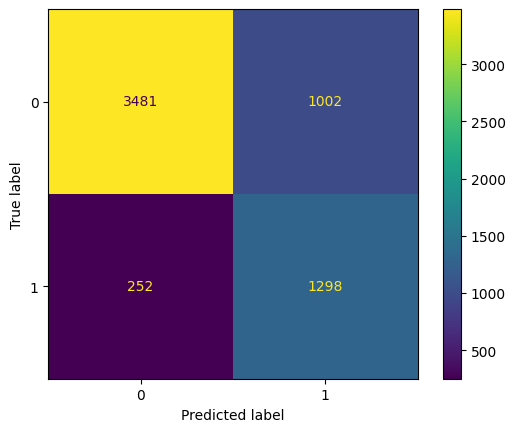

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

In [ ]:
pesos = pd.DataFrame(data=grid_search.best_estimator_.named_steps['model'].coef_.T,
                     index=grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out().tolist(), # Se extraen los nombres de las variables
                     columns=['Coeficiente'])
pesos.loc['intercepto'] = grid_search.best_estimator_.named_steps['model'].intercept_
pesos.sort_values(by='Coeficiente', ascending=False)

,Coeficiente
ohe_occupation__occupation_ Exec-managerial,0.877689
ohe_occupation__occupation_ Tech-support,0.683512
ohe_occupation__occupation_ Prof-specialty,0.612070
ohe_relationship__relationship_ Wife,0.600988
ohe_occupation__occupation_ Protective-serv,0.570319
pre_num__age,0.480913
pre_num__hours-per-week,0.459469
ohe_occupation__occupation_ Sales,0.433710
oe_education__education,0.293127
ohe_occupation__occupation_ Craft-repair,0.242678
